# CSE 5524 HW6 Utkarsh Pratap Singh Jadon

## Question 1

### Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray
import cv2 as cv
import numpy as np
import math
from PIL import Image
import glob
import os
import skimage
from os import listdir
from os.path import join, isfile
from skimage import morphology
from skimage import measure,color
from skimage import io, data 
from numpy.linalg import eig
from scipy import ndimage, misc
from scipy.ndimage import median_filter
import matplotlib.patches as patches

### Read and display input image

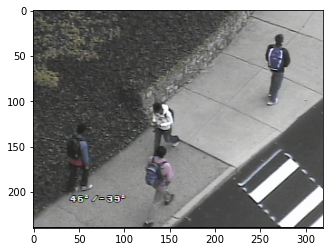

In [2]:
inputImage = skimage.io.imread('target.png')

plt.subplot(1,1,1)
plt.imshow(inputImage)
plt.show()

### Define model covariance matrix

In [4]:
modelCovMatrix = np.array(([47.917, 0, -146.636, -141.572, -123.269],
                           [0, 408.250, 68.487, 69.828, 53.479],
                           [-146.636, 68.487, 2654.285, 2621.672, 2440.381],
                           [-141.572, 69.828, 2621.672, 2597.818, 2435.368],
                           [-123.269, 53.479, 2440.381, 2435.368, 2404.923]))
print(modelCovMatrix.shape)

(5, 5)


### Generate list that contains all possible overlapping windows

In [374]:
a,b,c = inputImage.shape
featureList = []

for i in range(a-70):
    for j in range(b-24):
        window = np.zeros((70,24,5))
        for k in range(70):
            for l in range(24):
                xCoordinate = j + l
                yCoordinate = i + k
                R = inputImage[yCoordinate][xCoordinate][0]
                G = inputImage[yCoordinate][xCoordinate][1]
                B = inputImage[yCoordinate][xCoordinate][2]
                window[k][l] = xCoordinate, yCoordinate, R, G, B
        featureList.append(window)

### Reshape overlapping windows from 3D to 2D

In [375]:
featureListReshaped = []

for matrix in featureList:
    reshapedMatrix = matrix.reshape(matrix.shape[0]*matrix.shape[1],(matrix.shape[2]))
    featureListReshaped.append(reshapedMatrix)

### Calculate candidate covariance matrices and store in a list

In [376]:
candidateCovMatrix = []

for matrix in featureListReshaped:
    covMatrix = np.cov(matrix.transpose(),bias=True)
    candidateCovMatrix.append(covMatrix)

In [5]:
print(candidateCovMatrix[0].shape)

NameError: name 'candidateCovMatrix' is not defined

### Riemannian Manifold calculation

In [377]:
#Following section creates a list that contains distances of all candidate covariances from model covariance matrix

from scipy.linalg import eigh

distanceMetric = []
alpha = 0

for matrix in candidateCovMatrix:
    eigvals = eigh(modelCovMatrix, matrix, eigvals_only=True)
    for values in eigvals:
        if (values != 0):
            alpha += (math.log(values))**2
    beta = math.sqrt(alpha)
    distanceMetric.append(beta)
    alpha=0

### Display coordinates (x, y) of where maximum similarity is found

In [378]:
valueOfMaximumSimilarity = min(distanceMetric)
indexOfMaximumSimilarity = distanceMetric.index(valueOfMaximumSimilarity)
coordinatesOfMaximumSimilarity = featureListReshaped[indexOfMaximumSimilarity][0][0:2]

print("Minimum distance is: ")
print(valueOfMaximumSimilarity)
print("X & Y coordinates of maximum similarity is: ")
print(coordinatesOfMaximumSimilarity)

Minimum distance is: 
1.1496136026658719
X & Y coordinates of maximum similarity is: 
[251.  23.]


### Display match-distancing-image

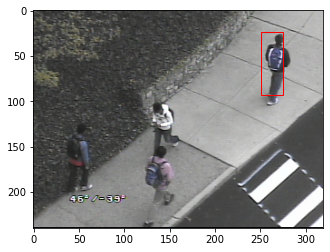

In [379]:
fig,ax = plt.subplots()
ax.imshow(inputImage)
rect = patches.Rectangle((coordinatesOfMaximumSimilarity),24,70,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

### Discussion

I calculated the location of best candidate which had minimum distance from provided covariance matrix using Riemannian Manifold after reshaping 3D covariance matrices of all possible windows to 2D in order to find generalised eigen values. I see that the origin for best match window was at (x = 251 & y = 23). Hence, I generated a window of size (x = 24 & y = 70) with its origin at the location of best match mentioned previously.

## Question 2

### Create function to extract feature vector of pixels in circular neighborhood

In [381]:
def circularNeighbors(img, x, y, radius):
    a,b,c = img.shape
    pixelLocations = []
    
    for i in range(a):
        for j in range(b):
            if (i - y)**2 + (j - x)**2 < radius**2:
                pixelLocations.append((j,i))
    
    K = len(pixelLocations)
    features = np.zeros((K,5))
    for l in range(K):
        xCoordinate = pixelLocations[l][0]
        yCoordinate = pixelLocations[l][1]
        R = img[yCoordinate][xCoordinate][0]
        G = img[yCoordinate][xCoordinate][1]
        B = img[yCoordinate][xCoordinate][2]
        features[l,:] = xCoordinate, yCoordinate, R, G, B
    return features

## Question 3

### Create function to build color histogram from neighborhood info

In [383]:
def colorHistogram(X, bins, x, y, h):

    a,b = X.shape
    hist = np.zeros((bins,bins,bins))
    for i in range(bins):
        for j in range(bins):
            for k in range(bins):
                for l in range(a):
                    if (X[l][2] < ((256 / bins)*i) and (X[l][2]) >= ((256 / bins)*(i-1)) and X[l][3] < ((256 / bins)*j) and (X[l][3]) >= ((256 / bins)*(j-1)) and X[l][4] < ((256 / bins)*k) and (X[l][4]) >= ((256 / bins)*(k-1))):
                        hist[i][j][k] += epanechnikov(x, y, X[l][0], X[l][1], h)
    hist = np.divide(hist, np.sum(hist))
    return hist
#Following section generates a function to get Epanechnikov kernel
    
def epanechnikov(x, y, xi, yi, h):
    r = (math.sqrt(((x-xi)**2) + ((y-yi)**2)) / h)**2
    k = 0
    if (r < 1):
        k = 1 - r
    else:
        k = 0
    return k
    

## Question 4

### Create function to calculate mean-shift weights vector

In [384]:
def meanShiftWeights(X, q_model, p_test, bins):
    a,b = X.shape
    w = np.zeros((a,1))
    
    for l in range(a):
        for i in range(bins):
            for j in range(bins):
                for k in range(bins):
                    if (X[l][2] < ((256 / bins)*i) and (X[l][2]) >= ((256 / bins)*(i-1)) and X[l][3] < ((256 / bins)*j) and (X[l][3]) >= ((256 / bins)*(j-1)) and X[l][4] < ((256 / bins)*k) and (X[l][4]) >= ((256 / bins)*(k-1))):
                        if(p_test[i][j][k] == 0):
                            w[l] = 0
                        else:
                            w[l] = math.sqrt(q_model[i][j][k] / p_test[i][j][k])
    return w

## Question 5

### Run 25 iterations of mean-shift tracking on inputImage2 and display final results

In [386]:
#Following sections generate q_model from inputImage 1

inputImage1 = skimage.io.imread('img1.png')
x0,y0 = 150.0,175.0
radius = 25
h = 25
bins = 16


X1 = circularNeighbors(inputImage1,x0,y0,radius)
q_model = colorHistogram(X1,bins,x0,y0,h)

#Following section performs 25 iterations of mean shift tracking on inputImage 2

Y = np.zeros((25,2))

inputImage2 = skimage.io.imread('img2.png')

for i in range(25):
    if (i == 0):
        X2 = circularNeighbors(inputImage2,x0,y0,radius)
        p_test = colorHistogram(X2, bins, x0, y0, h)
        w = meanShiftWeights(X2, q_model, p_test, bins)
        a,b = w.shape
    else:
        X2 = circularNeighbors(inputImage2, Y[i-1][0], Y[i-1][1], radius)
        p_test = colorHistogram(X2, bins, Y[i-1][0], Y[i-1][1], h)
        w = meanShiftWeights(X2, q_model, p_test, bins)
        a,b = w.shape
    
    for j in range(a):
        if (j == 0):
            Y[i][0] = (X2[j][0]*w[j]) / np.sum(w)
            Y[i][1] = (X2[j][1]*w[j]) / np.sum(w)
        else:
            Y[i][0] += (X2[j][0]*w[j]) / np.sum(w)
            Y[i][1] += (X2[j][1]*w[j]) / np.sum(w)
print(Y)

[[148.737589   174.66223254]
 [147.40739352 174.53135993]
 [146.64425871 174.47707292]
 [145.7270529  174.50429452]
 [145.07858848 174.55928789]
 [144.57059595 174.59141628]
 [144.13652806 174.59234558]
 [143.70191034 174.65486232]
 [142.84283876 174.69624468]
 [142.28902987 174.79617064]
 [142.07388845 174.817931  ]
 [141.90708824 174.85296634]
 [141.73178288 174.825005  ]
 [141.57658845 174.83933937]
 [141.2081615  174.87134898]
 [141.12658792 174.93534621]
 [141.11054906 174.94732205]
 [141.11866841 174.93891095]
 [141.11427356 174.94441221]
 [141.11677714 174.94092872]
 [141.11530774 174.94309828]
 [141.11618651 174.94175824]
 [141.1156557  174.94258217]
 [141.11597823 174.94207675]
 [141.11578167 174.94238638]]


### Final location and euclidean distance between last two iterations

In [388]:
print("Final locations is: ")
print(Y[24])

euclideanDistance = math.sqrt(((Y[24][0] - Y[23][0])**2) + ((Y[24][1] - Y[23][1])**2))
print("Euclidean distance between last two iterations is: ")
print(euclideanDistance)

Final locations is: 
[141.11578167 174.94238638]
Euclidean distance between last two iterations is: 
0.00036675127085808397


### Discussion

I built a q_model region model from inputImage1 by first finding its circular neighborhood and color histogram cube using Epanechnikov kernel. After running 25 iterations of mean shift tracking on inputImage2, I got the final location as (141.11578167, 174.94238638) and euclidean distance between last two iterations as 0.00036675127085808397